**This Notebook implements the TensorFlow advanced tutorial which uses a Multilayer Convolutional Network on the MNIST dataset**

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import time

Import MNIST Data

In [2]:
mnist = input_data.read_data_sets("../datasets/MNIST/", one_hot=True)

Extracting ../datasets/MNIST/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST/t10k-labels-idx1-ubyte.gz


Look at sizes of training, validation and test sets Each image is 28 X 28 pixels Labels are in one hot encoding for use with softmax

55000
5000
10000


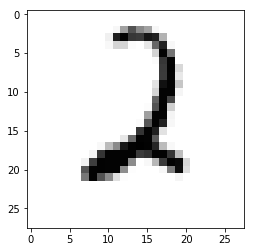

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [42]:
print(mnist.train.num_examples)
print(mnist.validation.num_examples)
print(mnist.test.num_examples)
plt.imshow(mnist.train.images[10004].reshape(28,28),cmap="Greys")
plt.show()
print (mnist.train.labels[10004])

Declare Variables

In [4]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

Weight Initialization for ReLU nodes

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Convolution and Pooling operations

In [6]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

**First Convolutional Layer**
The convolution will compute 32 features for each 5x5 patch. The max_pool_2x2 method will reduce the image size to 14x14.

In [7]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

**Second Convolutional Layer** The second layer will have 64 features for each 5x5 patch. 

In [8]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

**Densely Connected Layer** The image size has been reduced to 7x7 and we add a fully-connected layer with 1024 neurons to allow processing on the entire image.

In [9]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

**Dropout**

In [10]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

**Readout Layer**

In [11]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

**Implement Model**

In [12]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Define function that runs the model for given number of batches and returns the training time and accuracy on the validations and test data sets.

In [36]:
def train_and_test_model(batches,batches_per_epoch,verbose=False):
    start = time.time()
    epoch = 1
    results = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(batches):
            batch = mnist.train.next_batch(50)  
            if i % 100 == 0 and verbose:
                train_accuracy = accuracy.eval(feed_dict={
                    x: batch[0], y_: batch[1], keep_prob: 1.0})
                print('step %d, training accuracy %g, elapsedtime %g' % (i, train_accuracy, time.time() - start))
            train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
            if (i+1) % batches_per_epoch == 0:
                test_accuracy = accuracy.eval(feed_dict={
                    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
                validation_accuracy = accuracy.eval(feed_dict={
                    x: mnist.validation.images, y_: mnist.validation.labels, keep_prob: 1.0})
                if verbose:
                    print('Done with test/val accuracy elapsed time %g' % (time.time() - start))
                train_accuracy = accuracy.eval(feed_dict={
                    x: mnist.train.images[0:10000], y_: mnist.train.labels[0:10000], keep_prob: 1.0})
                if verbose:
                    print('Done with train accuracy elapsed time %g' % (time.time() - start))
                time_elapsed = time.time() - start
                if verbose:
                    print(epoch,i+1, time_elapsed, train_accuracy, validation_accuracy, test_accuracy)
                results.append((epoch,time_elapsed, train_accuracy, validation_accuracy, test_accuracy))
                epoch += 1
    return results

Try different number of epochs

In [38]:
results=train_and_test_model(7700,1100,verbose=True)
for r in results:
    print(r)

step 0, training accuracy 0.1, elapsedtime 0.280307
step 100, training accuracy 0.82, elapsedtime 22.0599
step 200, training accuracy 0.94, elapsedtime 39.533
step 300, training accuracy 0.94, elapsedtime 56.9026
step 400, training accuracy 0.94, elapsedtime 74.9775
step 500, training accuracy 0.98, elapsedtime 92.3506
step 600, training accuracy 0.98, elapsedtime 109.784
step 700, training accuracy 0.88, elapsedtime 127.871
step 800, training accuracy 0.98, elapsedtime 145.687
step 900, training accuracy 0.96, elapsedtime 163.3
step 1000, training accuracy 1, elapsedtime 180.715
Done with test/val accuracy elapsed time 221.807
Done with train accuracy elapsed time 236.237
1 1100 236.23753309249878 0.9658 0.969 0.9679
step 1100, training accuracy 1, elapsedtime 236.315
step 1200, training accuracy 0.98, elapsedtime 254.228
step 1300, training accuracy 1, elapsedtime 271.384
step 1400, training accuracy 1, elapsedtime 289.574
step 1500, training accuracy 1, elapsedtime 314.555
step 1600

Num Epochs | Train Time | Training Accuracy | Validation Accuracy | Test Accuracy
---------- | ---------- | ----------------- |-------------------- | -------------
1 |  236.2375 | 0.9658 | 0.9690 | 0.9679
2 |  524.6372 | 0.9800 | 0.9790 | 0.9756
3 |  782.5051 | 0.9869 | 0.9836 | 0.9820
4 | 1073.9373 | 0.9907 | 0.9860 | 0.9849
5 | 1317.5896 | 0.9933 | 0.9888 | 0.9878
6 | 1553.6760 | 0.9956 | 0.9904 | 0.9880
7 | 1781.1032 | 0.9965 | 0.9912 | 0.9896

The tutorial achieved 99.2% accuracy after 20000 batches, >18 epoch, in about 30 minutes. This notebook on my laptop, ran 7 epochs in about 30 minutes and achieved around 99% accuracy. We will use this as the benchmark to aim for the numpy based models.